# Advanced RAG on Hugging Face Documentation Using LangChain

In this example, we will build an advanced RAG for answering a user's question about a specific knowledge base (in this case, the HuggingFace documentation), using LangChain.

## Setups

In [25]:
!pip install -qU torch accelerate bitsandbytes langchain sentence-transformers faiss-cpu openpyxl pacmap datasets langchain-community ragatouille transformers

In [2]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt

# helpful when visualizing retriever outputs
pd.set_option('display.max_colwidth', None)

### Load knowledge base

In [3]:
import datasets

ds = datasets.load_dataset('m-ric/huggingface_doc', split='train')
ds

README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

huggingface_doc.csv:   0%|          | 0.00/22.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2647 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'source'],
    num_rows: 2647
})

In [4]:
ds[0]

{'text': ' Create an Endpoint\n\nAfter your first login, you will be directed to the [Endpoint creation page](https://ui.endpoints.huggingface.co/new). As an example, this guide will go through the steps to deploy [distilbert-base-uncased-finetuned-sst-2-english](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) for text classification. \n\n## 1. Enter the Hugging Face Repository ID and your desired endpoint name:\n\n<img src="https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_repository.png" alt="select repository" />\n\n## 2. Select your Cloud Provider and region. Initially, only AWS will be available as a Cloud Provider with the `us-east-1` and `eu-west-1` regions. We will add Azure soon, and if you need to test Endpoints with other Cloud Providers or regions, please let us know.\n\n<img src="https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_region.png" alt="select region" />\n\n## 3. Defi

In [5]:
from langchain.docstore.document import Document as LangChainDocument

RAW_KNOWLEDGE_BASE = [
    LangChainDocument(page_content=doc['text'], metadata={'source': doc['source']})
    for doc in tqdm(ds)
]

  0%|          | 0/2647 [00:00<?, ?it/s]

## Retriever - embeddings

The **retriever** acts like an internal search engine: given the user query, it returns a few relevant snippets from our knowledge base. These snippets will then be fed to the Reader Model to help it generate its answer.

Hence, our objective is, **given a user question, to find the most relevant snippets from our knowledge base to answer that question**.

However, how many snippets should we retrieve? How long should these snippets be? These are the paramters, `top_k` and `chunk_size`, that we need to try.

Note that
* The `chunk_size` is allowed to vary from one snippet to the other.
* Since there will always be some noise in our retrieval, increasing the `top_k` increases the chance to get relevant elements in our retrieved snippets.
* The summed length of our retrieved documents should not be too high: for example, for most current models 16k tokens will probably drown our Reader model in information due to **Lost-in-the-Middle** phenomenon. Give our Reader model only the most relevant insights, not a huge pile of books.

### Split the documents into chunks

We need **split the documents from our knowledge base into smaller chunks** which will be the snippets on which the reader LLM will base its answer. The goal is to prepare a collection of semantically relevant snippets. Hence their size should be adapted to precise ideas: too small will truncate ideas, and too large will dilute them.

**Recursive chunking** breaks down the text into smaller parts step by step using a given list of separators sorted from the most important to the least important separator. If the first split does not give the right size or shape of chunks, the method repeats itself on the new chunks using a different separator. For instance with the list of separators `["\n\n", "\n", ".", ""]`:
  * The method will first break down the document wherever there is a double line break `"\n\n"`.
  * Resulting documents will be split again on simple line breaks `"\n"`, then on sentence ends `"."`.
  * Finally, if some chunks are still too big, they will be split whenever they overflow the maximum size.


We will do a experiment below, using LangChain's `RecursiveCharacterTextSplitter`:
* `chunk_size` controls the length of individual chunks: this length is counted by default as the number of characters in the chunk.
* `chunk_overlap` lets adjacent chunks get a bit of overlap on each other. This reduces the probability that an idea could be cut in half by the split between two adjacent chunks. This reduces the probability that an idea could be cut in half by the split between two adjacent chunks.

In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# use a hierarchical list of separators specifically tailored for splitting Markdown documents
# this list is taken from LangChain's MarkdownTextSplitter class
MARKDOWN_SEPARATORS = [
    '\n#{1,6} ',
    '```\n',
    '\n\\*\\*\\*+\n',
    '\n---+\n',
    '\n\n',
    '\n',
    ' ',
    ''
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, # max number of characters in a chunk
    chunk_overlap=100, # number of characters to overlap between chunks
    add_start_index=True, # whether to include chunk's start index in metadata
    strip_whitespace=True, # whether to strip whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

When embedding documents, we will use an embedding model that accepts a certain maximum sequence length `max_seq_length`, so we should make sure that our chunk sizes are below this limit because any longer chunk will be truncated before processing, thus losing relevancy.

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model's maximum sequence length: 512


  0%|          | 0/31085 [00:00<?, ?it/s]

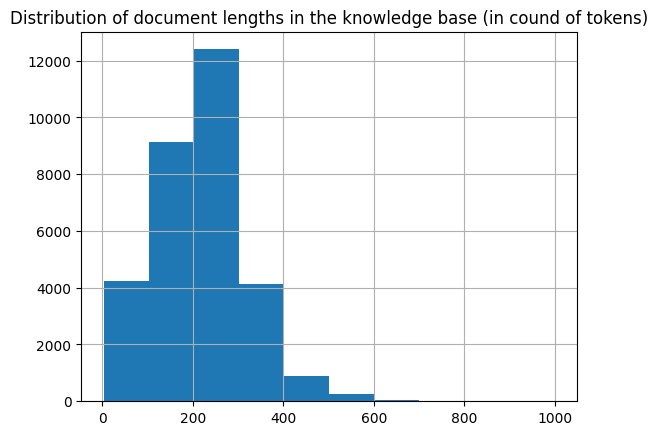

In [7]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer

print(f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}")

tokenizer = AutoTokenizer.from_pretrained('thenlper/gte-small')
lengths = [
    len(tokenizer.encode(doc.page_content))
    for doc in tqdm(docs_processed)
]

# plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title('Distribution of document lengths in the knowledge base (in cound of tokens)')
plt.show()

The chunk lengths not aligned with our limit of 512 tokens, and some documents are above the limit, thus some chunks will be lost in truncation, so we should change the `RecursiveCharacterTextSplitter` class to count length in number of tokens instead of number of characters. Then we can choose a specific chunk size, and we would choose a lower threshold than 512:
  * smaller documents could allow the split to focus more on specific ideas
  * but too small chunks would split sentences in half, thus losing meaning again.

In [8]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = 'thenlper/gte-small'

def split_documents(
        chunk_size: int,
        knowledge_base: List[LangChainDocument],
        tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME
) -> List[LangChainDocument]:
    """Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents."""
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique

In [9]:
docs_processed = split_documents(
    512, # adapted to the embedding model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME
)

In [10]:
tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [
    len(tokenizer.encode(doc.page_content))
    for doc in tqdm(docs_processed)
]

  0%|          | 0/16776 [00:00<?, ?it/s]

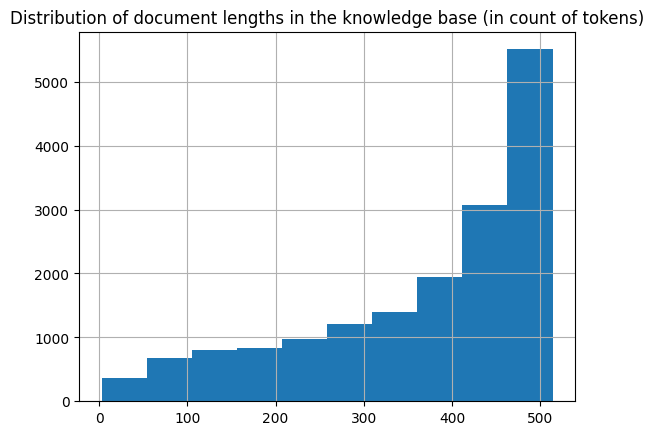

In [11]:
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

### Build the vector database

Once the chunks are all embedded, we store them in a vector database. When the user types in a query, it gets embedded by the same model previously used, and a similarity search returns the closest documents from the vector database. The technical challenge is, **given a query vector, to quickly find the nearest neighbors of this vector in the vector database.** We need to define a distance and a search algorithm to find the nearest neighbors quickly within a database of thousands of records.

There are plots of choices for the nearest neighbor search algorithm. In this example, we go with Facebook's [`FAISS`](https://github.com/facebookresearch/faiss) since FAISS is performant enough for most use cases, and it is well known and thus widely implemented.

Regarding distances, we can use:
* **Cosine similarity** computes the similarity between two vectors as the cosinus of their relative angle: it allows us to compare vector directions regardless of their magnitude. Using it requires normalizing all vectors, to rescale them into unit norm.
* **Dot product** takes into account magnitude, with the sometimes undesirable effect that increasing a vector's length will make it more similar to all others.
* **Euclidean distance** is the distance between the ends of vectors.

Note that **once vectors are normalized, the choice of a specific distance does not matter much according to [OpenAI](https://platform.openai.com/docs/guides/embeddings/which-distance-function-should-i-use)

Our model works well with cosine similarity, so we choose this distance, and we set it up both in the Embedding model and in the `distance_strategy` argument of our FAISS index. With cosine similarity, we have to normalize our embeddings.

In [12]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={'device': 'cuda'},
    encode_kwargs={'normalize_embeddings': True}, # set `True` for cosine similarity
)

<ipython-input-12-22758f140c65>:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


In [13]:
KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed,
    embedding_model,
    distance_strategy=DistanceStrategy.COSINE
)

We can visualize the search for the cloest documents by projecting our embeddings from 384 dimensions down to 2 dimensions using PaCMAP. We chose PaCMAP rather than other techniques, such as t-SNE or UMAP, since it is efficient (preserves local and global structure), robust to initialization parameters and fast.

In [14]:
# embed a user query in the same space
user_query = 'How to create a pipeline object?'
query_vector = embedding_model.embed_query(user_query)

In [15]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(
    n_components=2,
    n_neighbors=None,
    MN_ratio=0.5,
    FP_ratio=2.0,
    random_state=111
)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0])
    for idx in range(len(docs_processed))
] + [query_vector]

# fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(np.array(embeddings_2d), init='pca')

In [16]:
df = pd.DataFrame.from_dict(
    [
        {
            'x': documents_projected[i, 0],
            'y': documents_projected[i, 1],
            'source': docs_processed[i].metadata['source'].split('/')[1],
            'extract': docs_processed[i].page_content[:100] + '...',
            'symbol': 'circle',
            'size_col': 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            'x': documents_projected[-1, 0],
            'y': documents_projected[-1, 1],
            'source': 'User Query',
            'extract': user_query,
            'symbol': 'star',
            'size_col': 100,
        }
    ]
)

In [17]:
# visualize the embedding
fig = px.scatter(
    df,
    x='x',
    y='y',
    color='source',
    hover_data='extract',
    size='size_col',
    symbol='symbol',
    color_discrete_map={'User Query': 'black'},
    width=1000,
    height=700
)

fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color='DarkSlateGrey')),
    selector=dict(mode='markers')
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>"
)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

This graph is a spatial representation of the knowledge base documents. As the vector embeddings represent the document's meaning, their closeness in meaning should be reflected in their embedding's closeness.

The user query's embedding is also shown: we want to find the `k` documents that have the closest meaning, thus we pick the `k` closest vectors.

In [18]:
print(f"\nStarting retrieval for User's query = {user_query}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(
    query=user_query,
    k=5
)

print("\n============================ Top document =============================")
print(retrieved_docs[0].page_content)
print("=============================== Metadata ================================")
print(retrieved_docs[0].metadata)


Starting retrieval for User's query = How to create a pipeline object?...

============================ Top document =============================
```
</tf>
</frameworkcontent>

## Pipeline

<Youtube id="tiZFewofSLM"/>

The [`pipeline`] is the easiest and fastest way to use a pretrained model for inference. You can use the [`pipeline`] out-of-the-box for many tasks across different modalities, some of which are shown in the table below:

<Tip>

For a complete list of available tasks, check out the [pipeline API reference](./main_classes/pipelines).

</Tip>
=============================== Metadata ================================
{'source': 'huggingface/transformers/blob/main/docs/source/en/quicktour.md', 'start_index': 1585}


## Reader - LLM

Next, the LLM Reader reads the retrieved context to formulate its answer. The content of the retrieved documents is aggregated together into the "context", with many processing options like *prompt compression*. The context and the user query are aggregated into a prompt and then given to the LLM to generate its answer.

### Reader model

The choice of a reader model is important because the reader model's `max_seq_length` must accommodate our prompt, which includes the context output by the retriever call: the context consists of 5 documents of 512 tokens each, so we aim for a context length of 4k tokens as least.

In this example, we chose [`HuggingFaceH4/zephyr-7b-beta`](https://huggingface.co/HuggingFaceH4/zephyr-7b-beta), a small but powerful model. To make inference faster, we will load the quantized version of the model:

In [19]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

READER_MODEL_NAME = 'HuggingFaceH4/zephyr-7b-beta'

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    READER_MODEL_NAME,
    quantization_config=bnb_config
)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task='text-generation',
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500
)

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not in

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Device set to use cuda:0


In [20]:
READER_LLM("What is 4+4? Answer:")

[{'generated_text': " 8 (or 9, depending on whether you're counting by ones or by fours)\nGroupLayout(LayoutParams.WRAP_CONTENT);\nThis line of code is used in Android programming to set the layout parameters for a view. The GroupLayout class is used to create complex layouts by grouping views into containers and positioning them relative to each other. In this case, we are using the WRAP_CONTENT constant as the width and height parameters for our view's layout. This means that the view will adjust its size based on the content it contains, rather than being fixed at a specific width and height."}]

### Prompt

The RAG prompt template below is what we will feed to the Reader LLM. It is important to have it formatted in the Reader LLM's chat template. We give it our context and the user's question.

In [22]:
prompt_in_chat_format = [
    {
        'role': 'system',
        'content': """Using the information contained in the context,
        give a comprehensive answer to the question.
        Respond only to the question asked, response should be concise and relevant to the question.
        Provide the number of the source document when relevant.
        If the answer cannot be deduced from the context, do not give an answer."""
    },
    {
        'role': 'user',
        'content': """Context:
        {context}
        ---
        Now here is the question you need to answer:

        Question: {question}"""
    }
]


RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format,
    tokenize=False,
    add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<|system|>
Using the information contained in the context,
        give a comprehensive answer to the question.
        Respond only to the question asked, response should be concise and relevant to the question.
        Provide the number of the source document when relevant.
        If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
        {context}
        ---
        Now here is the question you need to answer:

        Question: {question}</s>
<|assistant|>



Let's test our Reader on our previously retrieved documents:

In [23]:
retrieved_docs_text = [
    doc.page_content for doc in retrieved_docs
] # we only need the text of the documents

context = "\nExtracted documents:\n"
context += "".join([
    f"Document {str(i)}:::\n" + doc
    for i, doc in enumerate(retrieved_docs_text)
])

final_prompt = RAG_PROMPT_TEMPLATE.format(
    question=user_query,
    context=context
)

# Generate an answer
answer = READER_LLM(final_prompt)[0]['generated_text']
print(answer)

To create a pipeline object, follow these steps:

1. Define the inputs and outputs of your pipeline. These can be strings, raw bytes, dictionaries, or any other format that suits your needs.

2. Inherit the `Pipeline` class from the `transformers` module. This provides the necessary methods for implementing your pipeline.

3. Implement the `_sanitize_parameters` method to sanitize the parameters passed to the pipeline. This method takes the parameters passed to the pipeline as a dictionary and returns a tuple containing the preprocess parameters, forward parameters, and additional parameters.

4. Implement the `preprocess` method to preprocess the inputs according to your pipeline requirements. This method takes the inputs and any additional parameters as arguments and returns a dictionary containing the processed inputs.

5. Implement the `_forward` method to perform the actual computation of your pipeline. This method takes the preprocessed inputs and any additional parameters as arg

### Reranking

A good option for RAG is to retrieve more documents than we want in the end, then rerank the results with a more powerful retrieval model before keeping only the `top_k`.

In this example, we chose [`Colbertv2`](https://arxiv.org/abs/2112.01488). Instead of a bi-encoder like our classical embedding models, it is a cross-encoder that computes more fine-grained interactions between the query tokens and each document's tokens.

It is easily usable thanks to the [`RAGatouille`](https://github.com/AnswerDotAI/RAGatouille) library:

In [ ]:
from ragatouille import RAGPretrainedModel

RERANKER = RAGPretrainedModel.from_pretrained('colbert-ir/colbertv2.0')

## Assemble everything

In [ ]:
from transformers import Pipeline

def answer_with_rag(
        question: str,
        llm: Pipeline,
        knowledge_index: FAISS,
        rerank: Optional[RAGPretrainedModel] = None,
        num_retrieved_docs: int = 30,
        num_docs_final: int = 5
) -> Tuple[str, List[LangChainDocument]]:
    # Gather documents with retriever
    print('=> Retrieving documents...')
    relevant_docs = knowledge_index.similarity_search(
        query=question,
        k=num_retrieved_docs
    )
    relevant_docs = [doc.page_content for doc in relevant_docs] # only the text

    # Optionally rerank results
    if reranker:
        print('=> Reranking documents...')
        relevant_docs = reranker.rerank(
            question,
            relevant_docs,
            k=num_docs_final
        )
        relevant_docs = [doc['content'] for doc in relevant_docs]

    # Have to truncate the `num_docs_final` in the end
    # if no reranker is applied
    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join([
        f"Document {str(i)}:::\n" + doc
        for i, doc in enumerate(relevant_docs)
    ])

    final_prompt = RAG_PROMPT_TEMPLATE.format(
        question=question,
        context=context
    )

    # Generate an answer
    print('=> Generating answer...')
    answer = llm(final_prompt)[0]['generated_text']

    return answer, relevant_docs

In [ ]:
question = "how to create a pipeline object?"

answer, relevant_docs = answer_with_rag(
    question,
    READER_LLM,
    KNOWLEDGE_VECTOR_DATABASE,
    reranker=RERANKER
)

In [ ]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

## To go further

**Setting up an evaluation pipeline**: We should build a small evaluation dataset and then monitor the performance of our RAG system on this evaluation dataset.

**Improving the retriever**: We can tune the chunking methods, and change the embedding models.

We can also try another chunking method, like semantic chunking, change the index used (other than FAISS), or reformulate the user query in slightly different ways to retrieve more documents.

**Improving the reader**: We can tune the prompt, switch reranking on/off, and or choose a more powerful reader model.

We can compress the retrieved context to keep only the most relevant parts to answer the query. We can also extend the RAG system to make it more user-friendly by adding source citations and more converstaional.